# Clothing Price Prediction Model

**Import La Garconne Dataset**

In [ ]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re

In [ ]:
url = 'https://raw.githubusercontent.com/hc4417/NYU-Data-Bootcamp-Final/refs/heads/main/lagarconne_products_cleaned.csv'
column_names = ['Retailer', 'Vendor', 'Category', 'Name', 'Price',
                'Product Link', 'Description', 'Product Details',
                'Description Lexical Diversity', 'Description Length',
                'Materials', 'Size Guide', 'Luxury Tier', 'Number of pictures',
                'Image Links']

lagar_df = pd.read_csv(url, names = column_names, skiprows=1)
lagar_df.head()

,Retailer,Vendor,Category,Name,Price,Product Link,Description,Product Details,Description Lexical Diversity,Description Length,Materials,Size Guide,Luxury Tier,Number of pictures,Image Links
0,La Garconne,Norlha,SCARF,Split Cape — Night,880.0,https://lagarconne.com/collections/all/product...,Norlha night black oversized open-front cape c...,Color: Night. 100% Yak Khullu. Handwoven in Ti...,100.00,33,['yak khullu'],True,Accessible Luxury,3,https://lagarconne.com/cdn/shop/files/Feb2021S...
1,La Garconne,Norlha,SCARF,Split Cape — Natural Yak Grey,880.0,https://lagarconne.com/collections/all/product...,Norlha natural grey oversized open-front cape ...,Color: Natural Yak Grey. 100% Yak Khullu. Hand...,100.00,33,['yak khullu'],True,Accessible Luxury,6,https://lagarconne.com/cdn/shop/files/Feb2021S...
2,La Garconne,Norlha,SCARF,Nomad Classic Scarf,425.0,https://lagarconne.com/collections/all/product...,Norlha midnight blue signature rectangular sca...,Color: Midnight Blue. 100% Yak Khullu. Handwov...,95.24,21,"['wool', 'yak khullu']",False,Affordable fashion,3,https://lagarconne.com/cdn/shop/files/Feb2021S...
3,La Garconne,Norlha,SCARF,Nomad Classic Skinny Scarf — Natural Yak Grey,295.0,https://lagarconne.com/collections/all/product...,Norlha natural grey signature rectangular scar...,Color: Natural Yak Grey. 100% Yak Khullu. Hand...,95.24,21,"['wool', 'yak khullu']",False,Affordable fashion,2,https://lagarconne.com/cdn/shop/files/Feb2021S...
4,La Garconne,Norlha,SCARF,Nomad Classic Skinny Scarf — Black,260.0,https://lagarconne.com/collections/all/product...,Norlha black signature rectangular scarf with ...,Color: Black. 100% Yak Khullu. Handwoven in Ti...,95.00,20,"['wool', 'yak khullu']",False,Affordable fashion,1,https://lagarconne.com/cdn/shop/files/Feb2021S...


###Building the Models


In [ ]:
# Setup & imports
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, FunctionTransformer
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.feature_extraction.text import TfidfVectorizer

**Data Preparation**

In [ ]:
# Image Embedding
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import torch

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTModel.from_pretrained("google/vit-base-patch16-224")
model.eval()

image_embeddings = []

for url in lagar_df['Image Links']:
    if url:
      # Load image from URL
      img = Image.open(requests.get(url, stream=True).raw).convert("RGB")

      # Preprocess and move to device
      inputs = processor(images=img, return_tensors="pt")

      with torch.no_grad():
        outputs = model(**inputs)
        emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token
        image_embeddings.append(emb[0])

    else:
        # Use zeros if no image
        image_embeddings.append(np.zeros(model.config.hidden_size))

image_embeddings = np.array(image_embeddings)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
X = lagar_df[['Category', 'Description', 'Number of pictures', 'Materials', 'Size Guide']]
y = lagar_df['Price']

# Train, test, split data (causes some data loss)
X_train, X_test, y_train, y_test, img_train, img_test = train_test_split(
    X, y, image_embeddings, test_size=0.2, random_state=42
)

# Convert image train and test to vertical array
img_train = np.vstack(img_train)
img_test  = np.vstack(img_test)

# Clean text columns
X_train['Description'] = X_train['Description'].fillna("missing").astype(str)
X_test['Description']  = X_test['Description'].fillna("missing").astype(str)

# Ensure non-empty strings
X_train['Materials'] = X_train['Materials'].apply(
    lambda lst: ' '.join([str(x).replace("'", "").replace('"', '').replace(' ', '') for x in lst])
                if isinstance(lst, list) and len(lst) > 0 else 'missing'
)
X_test['Materials'] = X_test['Materials'].apply(
    lambda lst: ' '.join([str(x).replace("'", "").replace('"', '').replace(' ', '') for x in lst])
                if isinstance(lst, list) and len(lst) > 0 else 'missing'
)

# Preprocess categorical
ohe = OneHotEncoder(drop = 'if_binary', sparse_output = False, handle_unknown='ignore')

# Preprocess num
num = StandardScaler()

# Preprocess long text (TfidfVectorizer turns words into numbers)
desc = Pipeline(steps = [
    ('function_transform', FunctionTransformer(lambda x: x['Description'], validate = False)),
    ('Tfidf', TfidfVectorizer(max_features = 300, stop_words=None ))
])

mat = Pipeline(steps = [
    ('function_transform', FunctionTransformer(lambda x: x['Materials'], validate = False)), # Turn materials list into string
    ('Tfidf', TfidfVectorizer(max_features = 200, stop_words=None))
])

# Encode
encoder = make_column_transformer(
    (ohe, ['Size Guide', 'Category']),
    (num, ['Number of pictures']),
    (desc, ['Description']),
    (mat, ['Materials']),
     remainder = 'passthrough')

X_train_encoded_base = encoder.fit_transform(X_train)
X_test_encoded_base = encoder.transform(X_test)

X_train_encoded_base = X_train_encoded_base.toarray()
X_test_encoded_base = X_test_encoded_base.toarray()

In [ ]:
# Combine X_trains
X_train_encoded = np.hstack([X_train_encoded_base, img_train])
X_test_encoded = np.hstack([X_test_encoded_base, img_test])

**Baselines**

In [ ]:
# Baseline 1: Simple Linear Regression Model
model = LinearRegression().fit(X_train_encoded, y_train)

# Linear MSE:
lin_mse_test = mean_squared_error(y_test, model.predict(X_test_encoded))
print('Linear Reg. Model MSE:', lin_mse_test)

# Linear RMSE:
lin_rmse = root_mean_squared_error(y_test, model.predict(X_test_encoded))
print('Linear Reg. Model RMSE:', lin_rmse)

Linear Reg. Model MSE: 915743.1071449369
Linear Reg. Model RMSE: 956.944672980072


In [ ]:
# Baseline 2: Global (Price) Mean Baseline
baseline_global = DummyRegressor(strategy = 'mean').fit(X_train_encoded,y_train)
y_test_pred = baseline_global.predict(X_test_encoded)

# Global MSE
global_mse_test = mean_squared_error(y_test, y_test_pred)
print('Global Price Baseline MSE:', global_mse_test)

# Global RMSE
global_rmse = root_mean_squared_error(y_test, y_test_pred)
print('Category Price Baseline RMSE:', global_rmse)

Global Price Baseline MSE: 485421.9600253918
Category Price Baseline RMSE: 696.7222976375823


In [ ]:
# Baseline 3: Category (Price) Mean Baseline
baseline_cat = y_train.groupby(X_train['Category']).mean()

y_test_pred_cat = X_test['Category'].map(baseline_cat).fillna(y_train.mean())

# Cat MSE
cat_mse_test = mean_squared_error(y_test, y_test_pred_cat)
print('Category Price Baseline MSE:', cat_mse_test)

# Cat RMSE
cat_rmse = root_mean_squared_error(y_test, y_test_pred_cat)
print('Category Price Baseline RMSE:', cat_rmse)


Category Price Baseline MSE: 303845.0344077776
Category Price Baseline RMSE: 551.2214023491628


**XGB Boosted & Random Forest Model**



In [ ]:
# @title #####GridSearch Optimize
#GridSearch Optimizer (Commented out takes ~30 mins to run)
'''
# Optimizing with Grid Search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_encoded, y_train)
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_encoded, y_train)
print(grid_search.best_params_)
'''

"\n# Optimizing with Grid Search\nparam_grid = {\n    'max_depth': [3, 5, 7],\n    'learning_rate': [0.05, 0.1],\n    'n_estimators': [100, 200]\n}\n\ngrid_search = GridSearchCV(\n    estimator=XGBRegressor(random_state=42),\n    param_grid=param_grid,\n    scoring='neg_mean_squared_error',\n    cv=3,\n    verbose=2,\n    n_jobs=-1\n)\n\ngrid_search.fit(X_train_encoded, y_train)\ngrid_search = GridSearchCV(\n    estimator=XGBRegressor(random_state=42),\n    param_grid=param_grid,\n    scoring='neg_mean_squared_error',\n    cv=3,\n    verbose=2,\n    n_jobs=-1\n)\n\ngrid_search.fit(X_train_encoded, y_train)\nprint(grid_search.best_params_)\n"

XGB Model

In [ ]:
# XGB fit
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
xgb.fit(X_train_encoded, y_train)

xgb_preds = xgb.predict(X_test_encoded)

# Performance Evaluation (MSE, etc.)
xgb_mse = mean_squared_error(y_test, xgb_preds)
xgb_rmse = root_mean_squared_error(y_test, xgb_preds)

print("XGBoost MSE:", xgb_mse)
print("XGBoost RMSE:", xgb_rmse)

XGBoost MSE: 196636.6817704257
XGBoost RMSE: 443.43734819072887


Random Forest Model

In [ ]:
# Random Forest Model
forest = RandomForestRegressor(n_estimators=100, random_state=42)
forest.fit(X_train_encoded, y_train)

forest_preds = forest.predict(X_test_encoded)

# Performance Evaluation (MSE, etc.)
forest_mse = mean_squared_error(y_test, forest_preds)
forest_rmse = root_mean_squared_error(y_test, forest_preds)

print("Random Forest MSE:", forest_mse)
print("Random Forest RMSE:", forest_rmse)

Random Forest MSE: 260259.66385760004
Random Forest RMSE: 510.156509178899


XGB Model RMSE < Random Forest RMSE  so we decided to move forward with the XGB model.

### Model Comparison Overview:

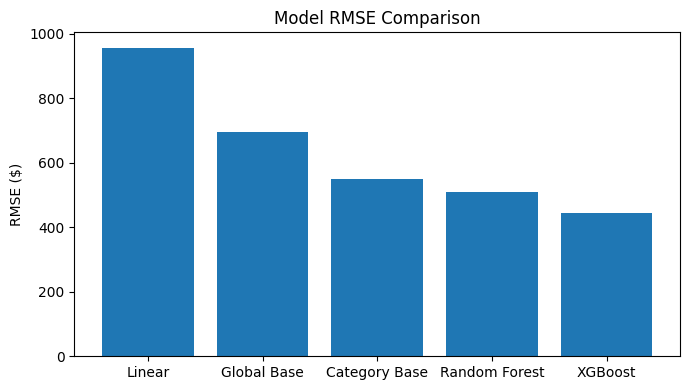

In [ ]:
# Model RMSE comparison chart
rmse_values = {
    'Linear': lin_rmse,
    'Global Base': global_rmse,
    'Category Base': cat_rmse,
    'Random Forest': forest_rmse,
    'XGBoost': xgb_rmse
}

plt.figure(figsize=(7,4))
plt.bar(rmse_values.keys(), rmse_values.values())
plt.ylabel("RMSE ($)")
plt.title("Model RMSE Comparison")
plt.tight_layout()
plt.show()

### XGB Model Results and Intepretation

**Predicted vs Actual Mean Prices**

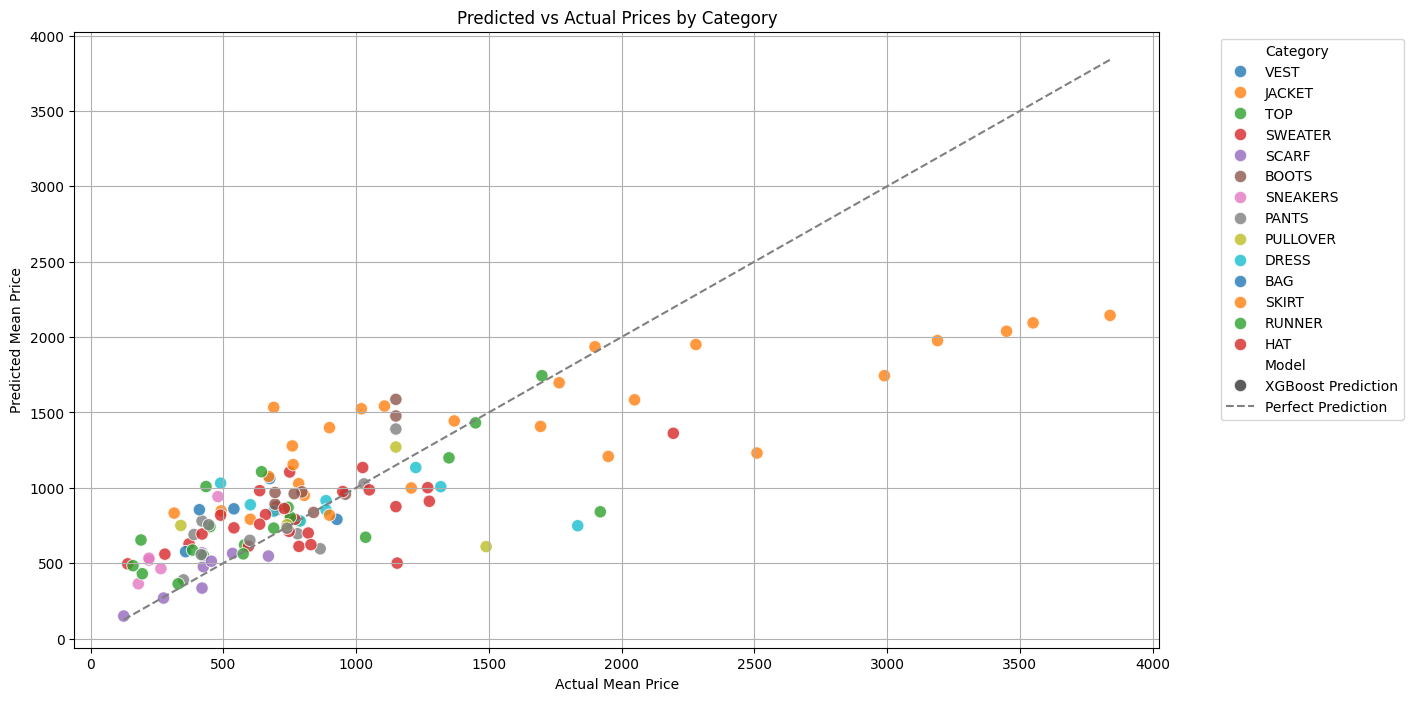

In [ ]:
# Prepare dataframe to compare predicted prices for XGB and Random Forest
comparison_df = pd.DataFrame({
    'Actual Price': y_test.values,
    'XGBoost Prediction': xgb_preds,
    'Category': X_test['Category'].values
})

# Combine data into long dataframe for plotting
final_df = comparison_df.melt(
    id_vars=['Actual Price', 'Category'],
    value_vars=['XGBoost Prediction'],
    var_name='Model',
    value_name='Predicted Price'
)

# Create plot
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=final_df,
    x='Actual Price',
    y='Predicted Price',
    hue='Category',
    style='Model',
    alpha=0.8,
    palette='tab10',
    s=80
)

# Create perfect prediction line
min_val = min(final_df['Actual Price'].min(), final_df['Predicted Price'].min())
max_val = max(final_df['Actual Price'].max(), final_df['Predicted Price'].max())
plt.plot([min_val, max_val], [min_val, max_val],
         color='gray', linestyle='--', label='Perfect Prediction')

plt.title('Predicted vs Actual Prices by Category')
plt.xlabel('Actual Mean Price')
plt.ylabel('Predicted Mean Price')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
# Category-level summary statistics
category_summary = comparison_df.groupby('Category').agg(
    predicted_mean_price = ('Actual Price', 'mean'),
    median_price = ('Actual Price', 'median'),
    min_price = ('Actual Price', 'min'),
    max_price = ('Actual Price', 'max'),
    iqr = ('Actual Price', lambda x: x.quantile(0.75) - x.quantile(0.25)),
    count = ('Actual Price', 'count')
).sort_values('predicted_mean_price')

In [ ]:
# Predicted vs. Actual Mean Prices Chart
# Actual mean prices
actual_means = (
    lagar_df.groupby("Category")["Price"]
    .mean()
    .reset_index()
    .rename(columns={"Price": "actual_mean_price"})
)

# Merge table
category_summary_with_actuals = category_summary.merge(
    actual_means, on="Category", how="left"
)

# Isolate predicted vs actual
predicted_vs_actual = category_summary_with_actuals.set_index('Category')[['predicted_mean_price', 'actual_mean_price']]
predicted_vs_actual['difference'] = (predicted_vs_actual['predicted_mean_price'] - predicted_vs_actual['actual_mean_price'])
predicted_vs_actual

,predicted_mean_price,actual_mean_price,difference
Category,,,
HAT,140.000000,259.380952,-119.380952
SNEAKERS,273.000000,406.785714,-133.785714
BAG,410.000000,1186.866667,-776.866667
SCARF,415.625000,463.744186,-48.119186
RUNNER,575.000000,609.000000,-34.000000
VEST,625.250000,686.636364,-61.386364
PANTS,653.363636,676.985075,-23.621438
TOP,746.444444,713.116883,33.327561
SWEATER,825.296296,900.043796,-74.747499


**Residual-Informed Pricing Ranges**


In [ ]:
# Residuals for XGBoost model
comparison_df['Residual'] = comparison_df['Actual Price'] - comparison_df['XGBoost Prediction']

# Absolute residuals (for buffer calculations)
comparison_df['Abs Residual'] = comparison_df['Residual'].abs()


In [ ]:
# Category specific residuals & expected pricing ranges
residual_buffer = comparison_df.groupby('Category')['Abs Residual'].mean().rename('Avg Residual')

# Expected Pricing Ranges Per Category
final_price_ranges = category_summary.join(residual_buffer)
final_price_ranges['Expected Low']  = final_price_ranges['predicted_mean_price'] - final_price_ranges['Avg Residual']
final_price_ranges['Expected High'] = final_price_ranges['predicted_mean_price'] + final_price_ranges['Avg Residual']

final_price_ranges[['Expected Low', 'predicted_mean_price', 'Expected High','Avg Residual']]

,Expected Low,predicted_mean_price,Expected High,Avg Residual
Category,,,,
HAT,-215.789886,140.000000,495.789886,355.789886
SNEAKERS,-18.505768,273.000000,564.505768,291.505768
BAG,-34.783997,410.000000,854.783997,444.783997
SCARF,349.790255,415.625000,481.459745,65.834745
RUNNER,562.029053,575.000000,587.970947,12.970947
VEST,359.513962,625.250000,890.986038,265.736038
PANTS,489.084567,653.363636,817.642706,164.279069
TOP,488.939501,746.444444,1003.949388,257.504944
SWEATER,603.333689,825.296296,1047.258903,221.962607


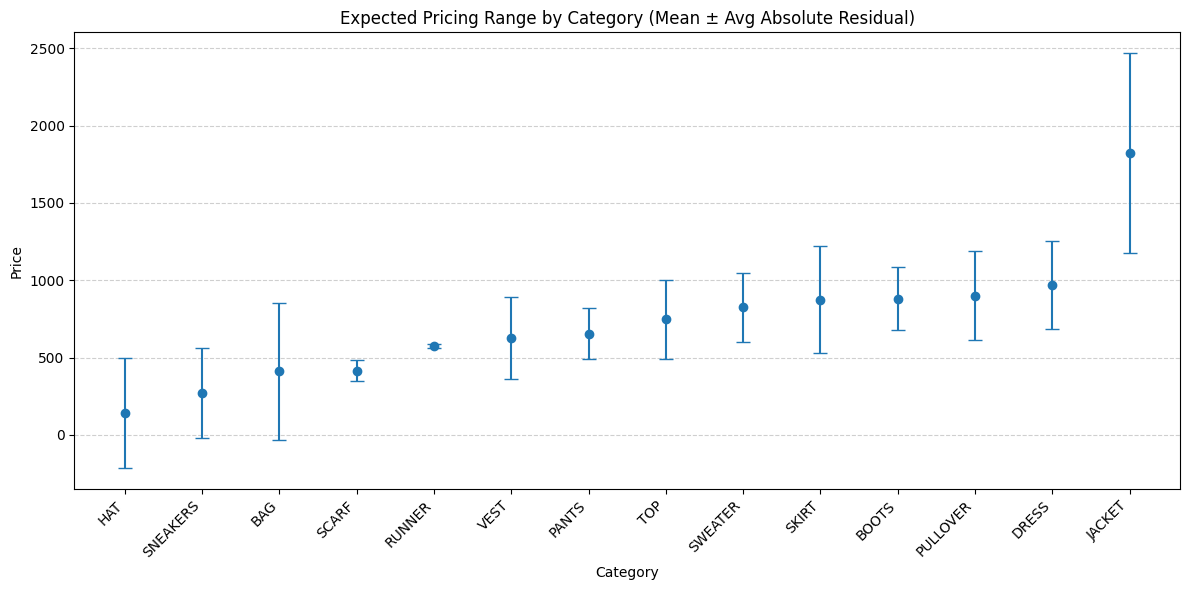

In [ ]:
# Sort categories by predicted mean price
plot_df = final_price_ranges.sort_values('predicted_mean_price')

# X positions
x = range(len(plot_df))

plt.figure(figsize=(12, 6))

# Error bars (Expected Low to Expected High)
plt.errorbar(
    x=x,
    y=plot_df['predicted_mean_price'],
    yerr=plot_df['Avg Residual'],
    fmt='o',
    capsize=5
)

# Labels & formatting
plt.xticks(x, plot_df.index, rotation=45, ha='right')
plt.ylabel('Price')
plt.xlabel('Category')
plt.title('Expected Pricing Range by Category (Mean ± Avg Absolute Residual)')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

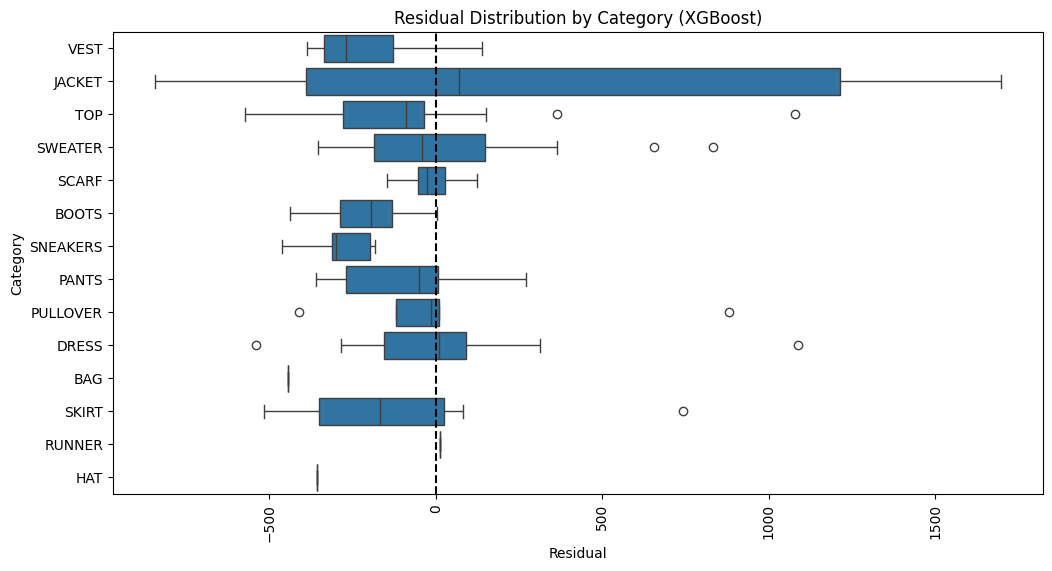

In [ ]:
# Plot category residuals
plt.figure(figsize=(12,6))
sns.boxplot(data=comparison_df, y='Category', x='Residual')
plt.xticks(rotation=90)
plt.title("Residual Distribution by Category (XGBoost)")
plt.axvline(0, color='black', linestyle='--')
plt.show()

### Feature Comparison

**Permutation Feature Importancce**

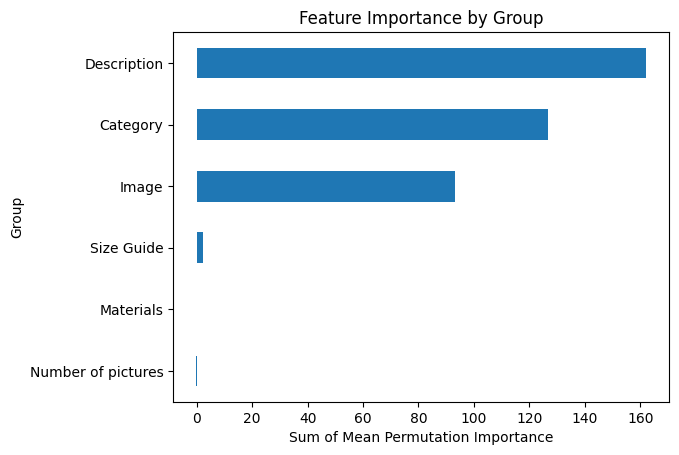

In [ ]:
# Compute permutation importance
result = permutation_importance(
    xgb,
    X_test_encoded,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='neg_root_mean_squared_error',
    n_jobs = -1
)

feature_names = []

cat_names = encoder.named_transformers_['onehotencoder'].get_feature_names_out(['Size Guide','Category'])
feature_names.extend(cat_names)
feature_names.extend(['Number of pictures'])

desc_names = encoder.named_transformers_['pipeline-1'].named_steps['Tfidf'].get_feature_names_out()
feature_names.extend([f'Description_{n}' for n in desc_names])

# TF-IDF features for Materials
mat_names = encoder.named_transformers_['pipeline-2'].named_steps['Tfidf'].get_feature_names_out()
feature_names.extend([f'Materials_{n}' for n in mat_names])

# Image embedding placeholders
img_cols = [f'img_{i}' for i in range(img_train.shape[1])]
feature_names.extend(img_cols)

# Permutation importance
result = permutation_importance(
    xgb,
    X_test_encoded,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

perm_importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values(by="importance_mean", ascending=False)

# Group features into respective categories
groups = []
for f in perm_importance_df['feature']:
    if 'Category' in f:
        groups.append('Category')
    elif 'Size Guide' in f:
        groups.append('Size Guide')
    elif 'Description' in f:
        groups.append('Description')
    elif 'Materials' in f:
        groups.append('Materials')
    elif 'img' in f:
        groups.append('Image')
    elif f == 'Number of pictures':
        groups.append('Number of pictures')
    else:
        groups.append('Other')

perm_importance_df['Group'] = groups

# Aggregate by group
grouped_importance = perm_importance_df.groupby('Group')['importance_mean'].sum()

# Horizontal bar plot
grouped_importance.sort_values().plot(kind='barh')
plt.xlabel("Sum of Mean Permutation Importance")
plt.title("Feature Importance by Group")
plt.show()

**Interpreting
 Coefficients of Linear Regression**

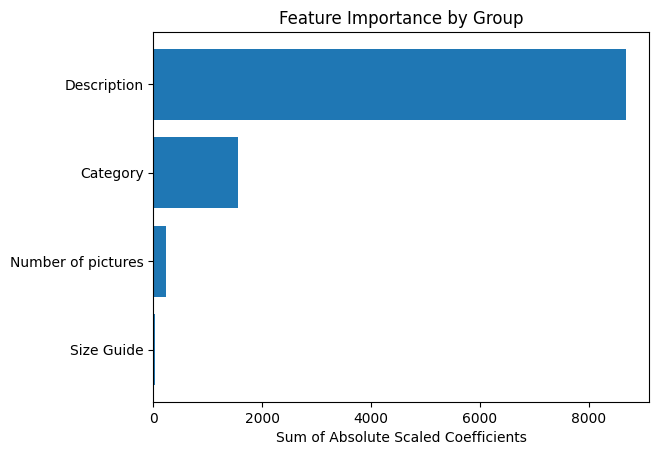

In [ ]:
# import OneHotEncoder
ohe = OneHotEncoder(drop = 'first', sparse_output = False)

# make column selector
selector = make_column_transformer(
    (ohe, ['Category', 'Description', 'Number of pictures', 'Materials', 'Size Guide']),
     remainder = 'passthrough')

# fit and transform
XT = selector.fit_transform(X_train)

# fit model
model_t = LinearRegression().fit(XT, y_train)

feature_names = selector.get_feature_names_out()

#Scale coefs
XT_std = XT.std(axis=0)
standardized_coef = model_t.coef_ * XT_std

# create df
std_coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Scaled Coefficient': standardized_coef })

std_coef_df['Group'] = std_coef_df['Feature'].apply(lambda x: x.split('__')[1].split('_')[0])

grouped_coefs = std_coef_df.groupby('Group')['Scaled Coefficient'].apply(lambda x: x.abs().sum()).sort_values(ascending=True)

# Bar plot by group
plt.barh(grouped_coefs.index, grouped_coefs.values)
plt.xlabel("Sum of Absolute Scaled Coefficients")
plt.title("Feature Importance by Group")
plt.show()

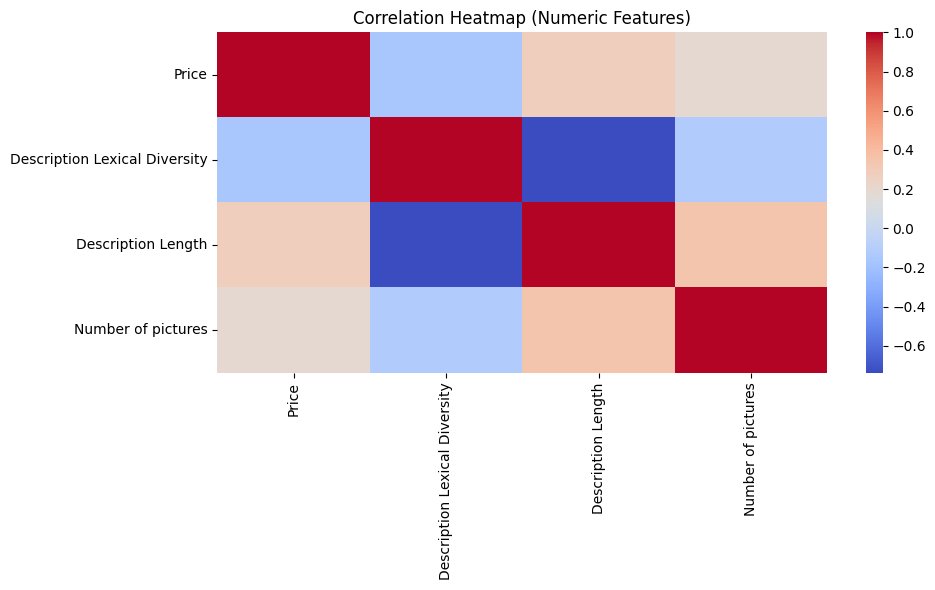

In [ ]:
plt.figure(figsize=(10,6))

# Select numeric columns only
numeric_df = lagar_df.select_dtypes(include=['int64','float64'])

corr = numeric_df.corr()

sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()